# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import round, sum, avg,count, countDistinct, col, concat, desc, explode, last, lit, min, max, split, udf, when, isnan
from pyspark.sql.types import IntegerType
from pyspark.sql.window import Window

from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import CountVectorizer, IDF, Normalizer, PCA, RegexTokenizer, StandardScaler, StopWordsRemover, StringIndexer, VectorAssembler, OneHotEncoder
from pyspark.ml.regression import LinearRegression
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import BinaryClassificationEvaluator

import re

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
spark = SparkSession.builder \
    .master("local") \
    .appName("Datascience Capstone Project") \
    .getOrCreate()

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [4]:
event_data = spark.read.json("mini_sparkify_event_data.json")

In [5]:
event_data.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [6]:
event_data = event_data.where(col('userId') != '')

In [7]:
event_data.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in event_data.columns]).show()

+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+
|artist|auth|firstName|gender|itemInSession|lastName|length|level|location|method|page|registration|sessionId| song|status| ts|userAgent|userId|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+
| 50046|   0|        0|     0|            0|       0| 50046|    0|       0|     0|   0|           0|        0|50046|     0|  0|        0|     0|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+



In [8]:
event_data.where(event_data.song.isNull()).select(event_data.page).distinct().show(100)
# This is due to the fact that only when the users click on NextSong, there is an Artist/Length or Song saved in the database

+--------------------+
|                page|
+--------------------+
|              Cancel|
|    Submit Downgrade|
|         Thumbs Down|
|                Home|
|           Downgrade|
|         Roll Advert|
|              Logout|
|       Save Settings|
|Cancellation Conf...|
|               About|
|            Settings|
|     Add to Playlist|
|          Add Friend|
|           Thumbs Up|
|                Help|
|             Upgrade|
|               Error|
|      Submit Upgrade|
+--------------------+



In [9]:
event_data.where(event_data.song.isNotNull()).select(event_data.page).distinct().show(100)

+--------+
|    page|
+--------+
|NextSong|
+--------+



We still have null values on artist, song and length because in those cases the action of the user was not related to a song, as shown in the previous cell.

# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

In [10]:
event_data.summary().show()

+-------+------------------+---------+---------+------+------------------+--------+-----------------+------+-----------------+------+-------+--------------------+------------------+--------------------+------------------+--------------------+--------------------+-----------------+
|summary|            artist|     auth|firstName|gender|     itemInSession|lastName|           length| level|         location|method|   page|        registration|         sessionId|                song|            status|                  ts|           userAgent|           userId|
+-------+------------------+---------+---------+------+------------------+--------+-----------------+------+-----------------+------+-------+--------------------+------------------+--------------------+------------------+--------------------+--------------------+-----------------+
|  count|            228108|   278154|   278154|278154|            278154|  278154|           228108|278154|           278154|278154| 278154|             

In [11]:
event_data.take(1)

[Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30')]

In [12]:
print("Number of rows of this subset: ")
event_data.count()

Number of rows of this subset: 


278154

In [13]:
print("Number of Users in this subset: ")
event_data.select("userId").distinct().count()

Number of Users in this subset: 


225

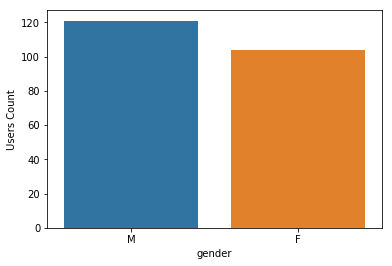

In [14]:
gender_count = event_data.groupby('gender').agg(countDistinct("userId").alias("Users Count")).sort(col('Users Count').desc())
sns.barplot(x='gender',y='Users Count',data=gender_count.toPandas());

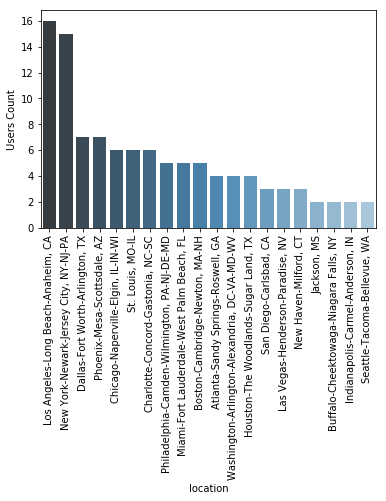

In [15]:
location_count = event_data.groupby('location').agg(countDistinct("userId").alias("Users Count")).sort(col('Users Count').desc()).limit(20)
location_plot = sns.barplot(x='location',y='Users Count',data=location_count.toPandas(), palette="Blues_d")
for item in location_plot.get_xticklabels():
    item.set_rotation(90)

In [16]:
print("List of different types of pages: ")
event_data.select(['page']).sort('page').distinct().show(23, False)

List of different types of pages: 
+-------------------------+
|page                     |
+-------------------------+
|About                    |
|Add Friend               |
|Add to Playlist          |
|Cancel                   |
|Cancellation Confirmation|
|Downgrade                |
|Error                    |
|Help                     |
|Home                     |
|Logout                   |
|NextSong                 |
|Roll Advert              |
|Save Settings            |
|Settings                 |
|Submit Downgrade         |
|Submit Upgrade           |
|Thumbs Down              |
|Thumbs Up                |
|Upgrade                  |
+-------------------------+



In [17]:
print("Number of sessions per user, ordered by sessions count: ")
event_data.groupby('userId').agg(count("sessionId").alias("sessionId Count")).sort(col('sessionId Count').desc()).show()

Number of sessions per user, ordered by sessions count: 
+------+---------------+
|userId|sessionId Count|
+------+---------------+
|    39|           9632|
|    92|           7230|
|   140|           6880|
|300011|           5732|
|   124|           4825|
|300021|           4659|
|300017|           4428|
|    85|           4370|
|    42|           4257|
|200023|           3769|
|     6|           3761|
|    29|           3603|
|    54|           3437|
|   100|           3214|
|     9|           3191|
|   126|           3102|
|300015|           3051|
|    91|           3014|
|    98|           2891|
|    74|           2887|
+------+---------------+
only showing top 20 rows



### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

In [18]:
churn_flag = udf(lambda x: 1 if x == 'Cancellation Confirmation' else 0, IntegerType())

event_data = event_data.withColumn("churn_flag", churn_flag('page'))

user_window = Window \
    .partitionBy('userId')

event_data = event_data.withColumn("churn", max(event_data.churn_flag).over(user_window))

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [19]:
event_data.groupby('churn').agg(countDistinct('userId').alias("Users Count")).show()

+-----+-----------+
|churn|Users Count|
+-----+-----------+
|    1|         52|
|    0|        173|
+-----+-----------+



In [20]:
event_data.groupby('gender', 'churn').agg(countDistinct("userId").alias("Users Count")).sort(col('Users Count').desc()).show()

+------+-----+-----------+
|gender|churn|Users Count|
+------+-----+-----------+
|     M|    0|         89|
|     F|    0|         84|
|     M|    1|         32|
|     F|    1|         20|
+------+-----+-----------+



In [21]:
event_data.groupby('level', 'churn').agg(countDistinct("userId").alias("Users Count")).sort(col('Users Count').desc()).show()

+-----+-----+-----------+
|level|churn|Users Count|
+-----+-----+-----------+
| free|    0|        149|
| paid|    0|        129|
| free|    1|         46|
| paid|    1|         36|
+-----+-----+-----------+



The same user can pass from free to paid or from paid to free, so the total counts exceed the total number of users in the dataset

In [22]:
event_data.groupby('auth', 'churn').agg(countDistinct("userId").alias("Users Count")).sort(col('Users Count').desc()).show()

+---------+-----+-----------+
|     auth|churn|Users Count|
+---------+-----+-----------+
|Logged In|    0|        173|
|Cancelled|    1|         52|
|Logged In|    1|         52|
+---------+-----+-----------+



Of course the users who churned are not anymore logged in and they end up in "Cancelled" type of authentication

In [23]:
event_data.groupby('status', 'churn').agg(countDistinct("userId").alias("Users Count")).sort(col('Users Count').desc()).show()

+------+-----+-----------+
|status|churn|Users Count|
+------+-----+-----------+
|   200|    0|        173|
|   307|    0|        171|
|   404|    0|         95|
|   307|    1|         52|
|   200|    1|         52|
|   404|    1|         22|
+------+-----+-----------+



Ratio for Users Count churn or not-churn does not seem to be affected by status

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

### Categorical Features

In [24]:
event_data_agg = event_data.select(["userId", "gender"]).distinct()

stringIndexer = StringIndexer(inputCol="gender", outputCol="genderIndexed")
stringIndexer = stringIndexer.fit(event_data_agg)
event_data_agg = stringIndexer.transform(event_data_agg)
   
encoder = OneHotEncoder(inputCol="genderIndexed", outputCol="genderFeature")
event_data_agg_cat = encoder.transform(event_data_agg)

In [25]:
event_data_agg_cat.show(10)

+------+------+-------------+-------------+
|userId|gender|genderIndexed|genderFeature|
+------+------+-------------+-------------+
|    44|     F|          1.0|    (1,[],[])|
|    46|     F|          1.0|    (1,[],[])|
|    41|     F|          1.0|    (1,[],[])|
|    72|     F|          1.0|    (1,[],[])|
|300023|     F|          1.0|    (1,[],[])|
|    39|     F|          1.0|    (1,[],[])|
|100010|     F|          1.0|    (1,[],[])|
|    40|     F|          1.0|    (1,[],[])|
|    94|     F|          1.0|    (1,[],[])|
|    35|     F|          1.0|    (1,[],[])|
+------+------+-------------+-------------+
only showing top 10 rows



In [37]:
event_data_agg_cat.count()

225

#### Side note on data leakage

In [26]:
# it would be useful to use the last value of level, but this could be an example of data leakage 
# as we are using an information that we might not have in production as it is in the future
spec = Window\
    .partitionBy('userId')\
    .orderBy(col('ts').desc())\
    .rowsBetween(Window.unboundedPreceding, Window.unboundedFollowing)

event_data_agg_1 = event_data.withColumn('lastLevel', last('level').over(spec)).select(['userId', 'lastLevel']).distinct()

### Numerical Features

In [27]:
#count of page actions for each uers
event_data_agg_2 = event_data.groupby('userId').pivot('page').count()
event_data_agg_2 = event_data_agg_2.fillna(0)

In [28]:
#number of sessions per user
event_data_agg_3 = event_data.groupby('userId').agg(count('sessionId').alias('numSessions'))

#number of songs per user
event_data_agg_4 = event_data.groupby('userId').agg(count('song').alias('numSongs'))

#average number of songs per user per session
event_data_agg_5 = event_data.groupby('userId', 'sessionId').agg(count('song').alias('numSongs')).groupby('userId').agg(round(avg('numSongs'), 1).alias('avgSongs'))

In [29]:
event_data_agg_num = event_data_agg_2.join(event_data_agg_3, ['userId'])\
                                     .join(event_data_agg_4, ['userId'])\
                                     .join(event_data_agg_5, ['userId'])

In [30]:
num_features = ["About","Add Friend","Add to Playlist","Cancel","Cancellation Confirmation","Downgrade","Error","Help","Home","Logout","NextSong","Roll Advert","Save Settings","Settings","Submit Downgrade","Submit Upgrade","Thumbs Down","Thumbs Up","Upgrade","numSessions","numSongs","avgSongs"]

assembler = VectorAssembler(inputCols=num_features, outputCol="NumFeatures")
event_data_agg_num = assembler.transform(event_data_agg_num)

In [31]:
scaler = StandardScaler(inputCol="NumFeatures", outputCol="ScaledNumFeatures", withStd=True)
scalerModel = scaler.fit(event_data_agg_num)
event_data_agg_num = scalerModel.transform(event_data_agg_num)

In [36]:
event_data_agg_num.count()

225

### Final Joins

In [39]:
event_data_agg_final = event_data_agg_cat.join(event_data_agg_num, ['userId']).join(event_data.select("userId", "churn").distinct(), ["userId"])

In [41]:
event_data_final = event_data_agg_final.select(col("churn").alias("label"), col("ScaledNumFeatures"), col("genderFeature"))

assembler2 = VectorAssembler(inputCols=['genderFeature', 'ScaledNumFeatures'], outputCol='all_features')
event_data_final = assembler2.transform(event_data_final)
event_data_final = event_data_final.select(event_data_final.label, event_data_final.all_features.alias('features'))

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

In [45]:
rest, validation = event_data_final.randomSplit([0.9, 0.1], seed=42)

In [46]:
# Defining ML model and pipeline step
lr = LogisticRegression(maxIter=10, regParam=0.0, elasticNetParam=0)

pipeline = Pipeline(stages=[lr])

In [47]:
# Defining hyper-parameters tuining
paramGrid = ParamGridBuilder() \
    .addGrid(lr.regParam,[0.0, 0.1]) \
    .addGrid(lr.elasticNetParam,[0.0, 0.5, 1.0]) \
    .build()

In [48]:
# Defining evalutation metrics
evaluator = BinaryClassificationEvaluator()\
    .setMetricName("areaUnderROC")

In [49]:
# ML pipeline initialization with Cross Validation
crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=3)

In [ ]:
# Model fitting
cvModel_q1 = crossval.fit(rest)

In [141]:
# Model testing
results = cvModel_q1.transform(validation)

In [142]:
# Evaluation 1: check counts of correct predictions
print(results.filter(results.label == results.prediction).count())
print(results.count())

27897
27897


In [ ]:
# Evaluation 2: using areaUnderROC to evaluate model
evaluator.evaluate(results)

# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.